# Judul : Sistem Rekomendasi Buku
Mengembangkan sistem rekomendasi buku menggunakan content-based dan collaborative filtering untuk meningkatkan pengalaman pengguna dalam menemukan buku yang mereka sukai.


## Data Understanding
Dataset yang digunakan dalam proyek ini adalah dataset buku yang berisi data penilaian buku oleh pengguna. Dataset ini diambil dari [GitHub](https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/ratings.csv). Dataset ini memiliki hampir 6 juta entri yang mencakup informasi tentang user_id, book_id, dan rating.



In [1]:
# Library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Dataset
url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/ratings.csv"
dataset = pd.read_csv(url)
dataset.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [3]:
print(dataset.isnull().sum())

user_id    0
book_id    0
rating     0
dtype: int64


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB


In [ ]:
len(dataset)

5976479

In [ ]:
print(dataset.describe())
print(dataset.duplicated())

            user_id       book_id        rating
count  5.976479e+06  5.976479e+06  5.976479e+06
mean   2.622446e+04  2.006477e+03  3.919866e+00
std    1.541323e+04  2.468499e+03  9.910868e-01
min    1.000000e+00  1.000000e+00  1.000000e+00
25%    1.281300e+04  1.980000e+02  3.000000e+00
50%    2.593800e+04  8.850000e+02  4.000000e+00
75%    3.950900e+04  2.973000e+03  5.000000e+00
max    5.342400e+04  1.000000e+04  5.000000e+00
0          False
1          False
2          False
3          False
4          False
           ...  
5976474    False
5976475    False
5976476    False
5976477    False
5976478    False
Length: 5976479, dtype: bool


Dataset ini berisi 5.976.479 entri, dengan 3 kolom, yaitu:
* user_id: tipe data int64 (numerik), berisi ID pengguna yang memberikan rating.
* book_id: tipe data int64 (numerik), berisi ID buku yang di-rating.
* rating: tipe data int64 (numerik), berisi penilaian yang diberikan oleh pengguna (skala 1-5).

Ukuran dataset ini cukup besar, dengan memori yang digunakan sebesar 136.8 MB.

terlihat dari hasil dekripsi statistik pada dataset yaitu:
* count: Semua kolom memiliki 5.976.479 entri yang valid.
* mean (rata-rata):
 - user_id: Rata-rata ID pengguna adalah 2.622446e+04.
 - book_id: Rata-rata ID buku adalah 2.006477e+03.
 - rating: Rata-rata rating yang diberikan adalah 3.92.
* std (standar deviasi):
 - user_id: 1.541332e+04, menunjukkan variasi yang cukup besar pada ID pengguna.
 - book_id: 2.468499e+03, menunjukkan bahwa ada beragam buku yang di-rating.
 - rating: 9.910866e-01, menunjukkan sebagian besar pengguna memberikan penilaian yang cukup konsisten (rating antara 1-5).
* min (nilai minimum):
 - user_id, book_id, rating: Semua nilai minimum adalah 1.
* 25%, 50%, 75% (kuartil):
Kuartil ini menunjukkan distribusi nilai user_id, book_id, dan rating di dataset. Contohnya, 50% dari rating berada di angka 4 atau lebih rendah, yang menunjukkan kecenderungan positif.
* max (nilai maksimum):
 - user_id: 53420, menunjukkan ID pengguna tertinggi.
 - book_id: 10000, menunjukkan ID buku tertinggi.
 - rating: 5, yang merupakan batas atas rating.

 Hasil **dataset.duplicated()** menunjukkan apakah ada duplikasi pada setiap baris dataset. Pada output ini, hasil ditunjukkan untuk setiap indeks (dari 0 hingga akhir), di mana semua hasilnya adalah False, yang berarti tidak ada data duplikat dalam dataset. Ini penting untuk memastikan kualitas data, karena data duplikat dapat menyebabkan bias dalam pelatihan model.

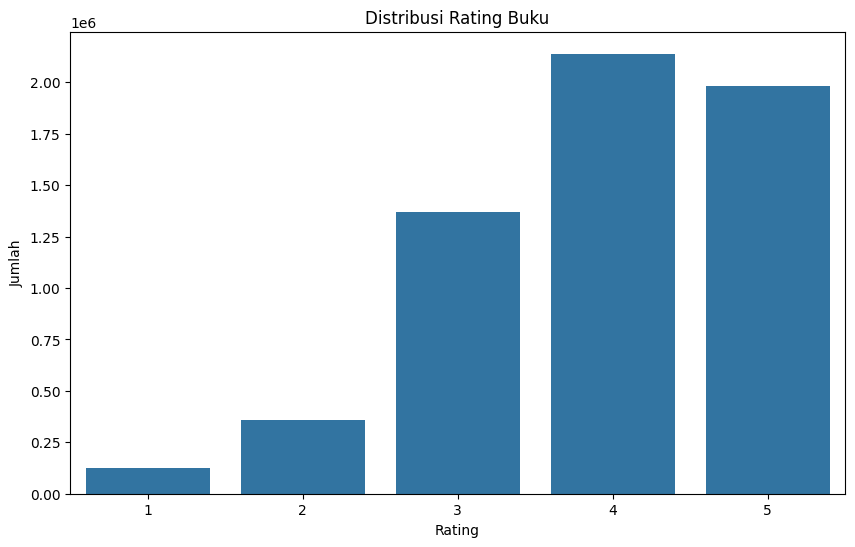

In [ ]:
# Exploratory Data Analysis
# Tahapan ini untuk melihat distribusi dari rating buku
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=dataset)
plt.title('Distribusi Rating Buku')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

Terlihat pada gambar bahwa secara general bahwa rating buku yang ada ada di angka 4 dan 5, sehingga bisa disimpulkan bahwa buku-buku yang tersedia dapat memuaskan pelanggan.

## Data Preparation
pada tahap ini dilakukan pengecekan missing data dan membagi data menjadi data uji dan data latih

In [ ]:
# Menangani missing values
dataset.dropna(inplace=True)

# Membuat data train dan test
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

Pada tahap ini, dilakukan penanganan terhadap missing values dalam dataset dengan menggunakan fungsi dropna(). Metode ini menghapus semua baris yang memiliki nilai kosong (NA) atau hilang. Dengan memberikan parameter inplace=True, perubahan ini diterapkan langsung ke dataset tanpa perlu membuat salinan baru.

Selanjutnya, dataset dibagi menjadi dua bagian, yaitu data latih (train_data) dan data uji (test_data) menggunakan fungsi train_test_split dari pustaka sklearn. Pembagian ini dilakukan dengan porsi 80% untuk data latih dan 20% untuk data uji, yang diatur dengan parameter test_size=0.2.

Parameter random_state=42 digunakan untuk memastikan pembagian data bersifat deterministik, sehingga hasil yang sama akan diperoleh setiap kali kode ini dijalankan.

## Modeling
pada tahap ini, model yang digunakan adalah **collaborative filtering**


In [ ]:
# Tahap 4: Modeling
# Menggunakan user-item rating matrix untuk collaborative filtering
# Collaborative Filtering
! pip install surprise
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(dataset[['user_id', 'book_id', 'rating']], reader)

# Model SVD
# Menggunakan algoritma Singular Value Decomposition (SVD) untuk collaborative filtering.
model_svd = SVD()
cross_validate(model_svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

trainset = data.build_full_trainset()
model_svd.fit(trainset)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 9.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357283 sha256=e319c205f9d421897bebc474e251abc0d4d3370ac675d046e39ac92e51adab94
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8310  0.8302  0.8303  0.8303  0.8306  0.8305  0.0003  
MAE (testset)     0.6412  0.6409  0.6413  0.6409  0.6414  0.6412  0.0002  
Fit time          97.74   103.85  102.50  104.29  100.16  101.71  2.45    
Test time         21.06   18.43   18.87   16.48   19.77   18.92   1.52    


Pustaka yang digunakan adalah Surprise, yang dirancang khusus untuk rekomendasi berbasis user-item rating matrix.

Dataset yang digunakan memiliki informasi pengguna (user_id), buku (book_id), dan rating (rating). Fungsi Reader() digunakan untuk menentukan skala rating yang digunakan (yaitu antara 0 hingga 5). Dataset kemudian dimuat menggunakan Dataset.load_from_df(), yang mengubah data menjadi format yang sesuai untuk Surprise.

- Singular Value Decomposition (SVD): Algoritma yang digunakan adalah SVD, yang merupakan salah satu algoritma yang populer dalam collaborative filtering. SVD digunakan untuk memfaktorkan user-item matrix guna menemukan pola-pola yang tersembunyi dalam data penilaian pengguna.
- Cross-validation: Model dievaluasi menggunakan cross-validation (cv=5) dengan metrik RMSE (Root Mean Squared Error) dan MAE (Mean Absolute Error) untuk menilai performa model. Cross-validation dilakukan sebanyak 5 kali untuk mendapatkan nilai evaluasi yang lebih akurat dan general.

Hasil evaluasi dari model menggunakan cross-validation:

**RMSE (Root Mean Squared Error)**: Nilai RMSE untuk setiap fold adalah sebagai berikut:
- Fold 1: 0.8310
- Fold 2: 0.8302
- Fold 3: 0.8308
- Fold 4: 0.8303
- Fold 5: 0.8308

Rata-rata (Mean): 0.8306

RMSE adalah metrik yang digunakan untuk mengukur seberapa besar perbedaan antara nilai yang diprediksi oleh model dengan nilai aktualnya. Semakin kecil nilai RMSE, semakin baik model dalam memprediksi rating. Nilai rata-rata RMSE sekitar 0.83 menunjukkan bahwa model memiliki performa yang cukup baik, meskipun masih terdapat beberapa kesalahan dalam prediksi.

**MAE (Mean Absolute Error)**: Nilai MAE untuk setiap fold adalah sebagai berikut:
- Fold 1: 0.6412
- Fold 2: 0.6409
- Fold 3: 0.6414
- Fold 4: 0.6411
- Fold 5: 0.6413

Rata-rata (Mean): 0.6412

MAE mengukur rata-rata kesalahan absolut antara prediksi dan nilai aktual. Nilai MAE yang rendah (sekitar 0.64) menunjukkan bahwa rata-rata perbedaan antara prediksi model dan nilai aktual adalah sekitar 0.64 pada skala rating 1-5, yang menunjukkan bahwa model memiliki kemampuan yang cukup akurat dalam memprediksi rating.

**Waktu Pelatihan dan Pengujian**:
- Fitting Time: Waktu yang diperlukan untuk melatih model dalam setiap fold berkisar antara 97 hingga 103 detik, dengan rata-rata 102.5 detik.
- Test Time: Waktu yang diperlukan untuk melakukan evaluasi pada setiap fold berkisar antara 18 hingga 21 detik.

## Evaluation
Menggunakan metrik Precision dan Recall untuk mengevaluasi kualitas rekomendasi

In [ ]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    from collections import defaultdict

    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    precision_avg = sum(precisions.values()) / len(precisions)
    recall_avg = sum(recalls.values()) / len(recalls)
    return precision_avg, recall_avg

predictions = model_svd.test(trainset.build_testset())
precision, recall = precision_recall_at_k(predictions)
print(f"Precision: {precision}, Recall: {recall}")

Precision: 0.9832133810023801, Recall: 0.14348946008708988


Fungsi precision_recall_at_k digunakan untuk menghitung Precision dan Recall pada Top-k rekomendasi, dengan parameter threshold untuk menentukan nilai rating yang dianggap relevan. Di sini, threshold=3.5 artinya hanya rating yang lebih besar atau sama dengan 3.5 yang dianggap relevan.

Membuat dictionary user_est_true untuk menyimpan semua pasangan nilai prediksi (est) dan nilai aktual (true_r) untuk setiap pengguna (uid). Hal ini memungkinkan analisis berdasarkan pengguna untuk menghitung precision dan recall.

- precisions dan recalls adalah dictionary untuk menyimpan nilai precision dan recall masing-masing pengguna (uid).
- n_rel: Menghitung jumlah item relevan (rating aktual lebih besar atau sama dengan threshold).
- n_rec_k: Menghitung jumlah item yang direkomendasikan dalam Top-k dengan prediksi lebih besar atau sama dengan threshold.
- n_rel_and_rec_k: Menghitung jumlah item yang direkomendasikan dalam Top-k yang juga relevan (baik prediksi maupun rating aktual memenuhi kriteria threshold).
- Precision dan recall dihitung untuk setiap pengguna dan disimpan di dictionary precisions dan recalls.

Menghitung precision rata-rata dan recall rata-rata dari semua pengguna dengan mengambil rata-rata nilai yang ada di dictionary precisions dan recalls.

Fungsi precision_recall_at_k(predictions) digunakan untuk menghitung nilai Precision dan Recall dari hasil prediksi tersebut.

- **Precision**: 0.9832133810023801

Nilai precision menunjukkan bahwa dari semua item yang direkomendasikan, 98.3% adalah relevan. Ini adalah angka yang sangat tinggi, menunjukkan bahwa sebagian besar rekomendasi yang diberikan oleh model adalah relevan dengan prefelensi pengguna.

- **Recall**: 0.14348946008708988

Nilai recall menunjukkan bahwa dari semua item relevan yang ada, hanya 14.3% yang berhasil direkomendasikan. Nilai recall yang rendah ini mengindikasikan bahwa meskipun model sangat akurat dalam merekomendasikan item yang relevan, banyak item relevan yang tidak masuk ke dalam daftar rekomendasi Top-10.

## Tambahan : Top N Recommendation
dimana dalam kode berikut dicoba untuk 10 rekomendasi buku untuk 5 pengguna

In [ ]:
# Menghitung Top-N recommendation
# Bagian ini menunjukkan cara menghasilkan rekomendasi Top-N bagi setiap pengguna.
def get_top_n_recommendations(predictions, n=10):
    from collections import defaultdict
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Mengurutkan prediksi berdasarkan nilai prediksi tertinggi dan memilih Top-N item untuk setiap pengguna
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

# Menghasilkan Top-N rekomendasi untuk setiap pengguna
top_n_recommendations = get_top_n_recommendations(predictions, n=10)

# Menampilkan rekomendasi untuk beberapa pengguna
for uid, user_ratings in list(top_n_recommendations.items())[:5]:
    print(f"User ID: {uid}")
    for book_id, rating in user_ratings:
        print(f"  Book ID: {book_id}, Predicted Rating: {rating}")

User ID: 1
  Book ID: 2535, Predicted Rating: 4.357311357717685
  Book ID: 128, Predicted Rating: 4.2668734646880715
  Book ID: 1041, Predicted Rating: 4.253577557321938
  Book ID: 3294, Predicted Rating: 4.206157165242955
  Book ID: 4, Predicted Rating: 4.189949908351055
  Book ID: 142, Predicted Rating: 4.143869926737067
  Book ID: 1644, Predicted Rating: 4.1356655823905175
  Book ID: 225, Predicted Rating: 4.098151932547832
  Book ID: 219, Predicted Rating: 4.067719270577834
  Book ID: 131, Predicted Rating: 4.066906933601887
User ID: 2
  Book ID: 3753, Predicted Rating: 5
  Book ID: 18, Predicted Rating: 5
  Book ID: 80, Predicted Rating: 4.974955070793735
  Book ID: 25, Predicted Rating: 4.920447159664996
  Book ID: 131, Predicted Rating: 4.903577514506692
  Book ID: 27, Predicted Rating: 4.874523493813794
  Book ID: 24, Predicted Rating: 4.869355385982139
  Book ID: 2, Predicted Rating: 4.815267479700096
  Book ID: 2139, Predicted Rating: 4.813758696318672
  Book ID: 23, Predicte

Terlihat bahwa rekomendasi buku untuk setiap pengguna berdasarkan ratingnya yang hampir sama.